# Text Mining Project Work (Team 1)

**Opinion Mining on Amazon Reviews with Logistic Regression and Deep Learning Models on top of TF-IDF Features**

_Prof. Gianluca Moro, Prof. Giacomo Frisoni – DISI, University of Bologna_

name.surname@unibo.it


**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Instructions
- The provided exercises must be executed by the students of Team 1.
- At the end, the file must contain all the required results (as code cell outputs) along with all the commands necessary to reproduce them.
- The function of every command or group of related commands must be documented clearly and concisely.
- The submission deadline is March 18th, 2024.
- When finished, one team member will send the notebook file (having .ipynb extension) via mail (using your BBS email account) to the teacher (giacomo.frisoni@unibo.it) indicating “[BBS Teamwork] Your last names” as subject, also keeping an own copy of the file for safety.
- You are allowed to consult the teaching material and to search the Web for quick reference.
- If still in doubt about anything, ask the teacher.
- It is severely NOT allowed to communicate with other teams. Ask the teacher for any clarification about the exercises.
- Each correctly developed point counts 2/30.

## Setup

The following cell contains some necessary imports.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
from urllib.request import urlretrieve

import warnings
warnings.filterwarnings("ignore")

random_state = 42

Run the following to download the necessary files.

In [3]:
def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

In [4]:
download(
    "Magazine_Subscriptions.json.gz",
    "https://www.dropbox.com/s/g6om8q8c8pvirw8/Magazine_Subscriptions.json.gz?dl=1",
)

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/jcbraz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Exercises

**1)** In the `Magazine_Subscriptions.json.gz` file, we provide a dataset composed of several reviews posted on Amazon.com about Magazine Subscriptions.
That file is a compressed .gzip, so you must open it using a .gzip decompression library.

Each review is labeled with a score between 1 and 5 stars (represented by the ```overall``` feature).

The text of each review is represented by the ```reviewText``` feature, which will be our input data along with the ```overall``` one.

Load the dataset by putting it in a new Pandas dataframe. The data is stored as a JSON file, so you will have to use a Python package to load JSON data into a variable.

In [6]:
with gzip.open("Magazine_Subscriptions.json.gz", "r") as f:
    data = [json.loads(line) for line in f]

**2)** Print the dataset rows number and visualize the first 5 rows.

In [7]:
X0 = pd.DataFrame(data)
print(f"Row number in the dataset: {X0.shape[0]}")
X0.head()

Row number in the dataset: 89689


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5.0,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5.0,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3.0,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5.0,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5.0,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


In [8]:
print(f"Overall column values: {X0['overall'].value_counts()}")

Overall column values: overall
5.0    53790
4.0    12676
1.0    11029
3.0     6971
2.0     5223
Name: count, dtype: int64


**3)** Undersample the data by `overall` feature in order to obtain a class-balanced dataset.



In [9]:
rus = RandomUnderSampler(random_state=42)
X = pd.DataFrame(X0.drop(columns=["overall"]))
y = pd.Series(X0["overall"])

X_resampled, y_resampled = rus.fit_resample(X, y)
X1 = pd.DataFrame(X_resampled, columns=X.columns)
X1.insert(0, "overall", y_resampled)
X1.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
57755,1.0,22,False,"08 14, 2007",A2P7ETBL7020DF,B000O1PKOG,Gary Smith,This magazine has a catchy title and very nice...,Just plain lame.,1187049600,{'Format:': ' Print Magazine'},NaN
12104,1.0,3,False,"01 9, 2014",AONC3Q7956CQ6,B00005N7T5,J-Lick,Before it was easy to go directly to the New Y...,Very Dissapointed in the on line format,1389225600,{'Format:': ' Kindle Edition'},NaN
44124,1.0,11,False,"09 7, 2009",A9004RLMUCQCJ,B00077B7M6,PT,I don't really understand why this product is ...,Extremely Expensive,1252281600,{'Format:': ' Kindle Edition'},NaN
70981,1.0,NaN,False,"10 9, 2015",A1DEYML4ZKN1WV,B00HG1BP0U,Angie,Looked nicer in the picture,One Star,1444348800,{'Format:': ' Print Magazine'},NaN
56361,1.0,NaN,True,"07 23, 2014",A3ULPJ814I5LP6,B000IOEK7M,John,Never received.,One Star,1406073600,NaN,NaN


In [10]:
X1["overall"].value_counts()

overall
1.0    5223
2.0    5223
3.0    5223
4.0    5223
5.0    5223
Name: count, dtype: int64

**4)** Cast the `reviewText` column to unicode string.

In [11]:
X1["reviewText"] = X1["reviewText"].astype("unicode")
display(X1["reviewText"].head())

57755    This magazine has a catchy title and very nice...
12104    Before it was easy to go directly to the New Y...
44124    I don't really understand why this product is ...
70981                          Looked nicer in the picture
56361                                      Never received.
Name: reviewText, dtype: object

**5)** Choose only the attributes labeled as ```reviewText``` and ```overall``` from the dataset, and place them into a dataframe.



In [12]:
review_text_col = pd.Series(X1["reviewText"])
overall_col = pd.Series(X1["overall"])

X2 = pd.DataFrame({"reviewText": review_text_col, "overall": overall_col})
X2['overall'] = X2['overall'].map(lambda x: int(x))
X2.head()

,reviewText,overall
57755,This magazine has a catchy title and very nice...,1
12104,Before it was easy to go directly to the New Y...,1
44124,I don't really understand why this product is ...,1
70981,Looked nicer in the picture,1
56361,Never received.,1


**6)** Verify the distribution of the number of stars.

<Axes: xlabel='overall', ylabel='Count'>

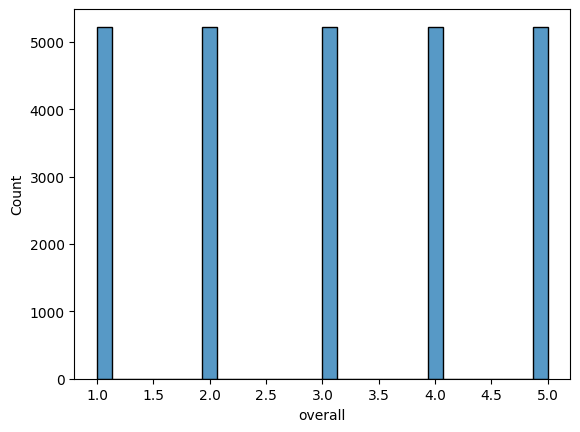

In [13]:
sns.histplot(X2["overall"], kde=False)

**7)** Remove from the dataframe the reviews rated with 3 stars.

In [14]:
rows_to_remove = X2.loc[X2['overall'] == 3]
X2 = X2.drop(rows_to_remove.index)
X2['overall'].value_counts()

overall
1    5223
2    5223
4    5223
5    5223
Name: count, dtype: int64

**8)** Add a `label` column to the DataFrame whose value is `"pos"` for reviews with 4 stars, `"very_pos"` for 5-rated reviews, `"neg"` for reviews with 2 stars, and `"very_neg"` for 1-rated reviews.

In [15]:
label_dict = {1: "very_neg", 2: "neg", 4: "pos", 5: "very_pos"}
X2["label"] = X2["overall"].map(label_dict)
X2["label"].value_counts()

label
very_neg    5223
neg         5223
pos         5223
very_pos    5223
Name: count, dtype: int64

**9)** Split the dataset randomly into a training set with 70% of data and a test set with the remaining 30%, stratifying the split by the `label` variable.

In [16]:
X, y = pd.DataFrame(X2.drop(columns=['label'])), pd.Series(X2["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14624, 2), (6268, 2), (14624,), (6268,))

**10)** Create a tf.idf vector space model from training reviews excluding words appearing in less than 3 documents and using bigrams in addition to single words. Then, extract the document-term matrix for them.

In [17]:
vectorizer = TfidfVectorizer(
    min_df=3,
    ngram_range=(1, 2),
    stop_words="english",
    tokenizer=nltk.word_tokenize,
    use_idf=True,
    sublinear_tf=True,
    smooth_idf=True,
)


X_train_features = vectorizer.fit_transform(X_train["reviewText"])
X_train_features.shape

(14624, 29268)

**11)** Train a logistic regression classifier on the training reviews, using the representation created above.

Notes: 
- Models excluding the Logistic Regression are defined in order to be used in point 14.
- Cross Validation is used in order to improve the model's performance.

In [18]:
models_details = {
    'lgr': {
        'model': LogisticRegression(max_iter=3000),
        'params': {}
    },
    'mlp': {
        'model': MLPClassifier(),
        'params': {
            "max_iter": [2000, 3000, 4000],
            'hidden_layer_sizes': [(100,), (200,), (300,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'max_iter': [200, 300, 400],
        }
    },
    'rnn': {
        'model': MLPClassifier(),
        'params': {
            'hidden_layer_sizes': [(100,), (200,), (300,)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'max_iter': [200, 300, 400],
            'solver': ['lbfgs']
        }
    }
}

In [19]:
lgre_clf = GridSearchCV(
    models_details['lgr']['model'],
    models_details['lgr']['params'],
    cv=StratifiedKFold(n_splits=5),
    scoring="accuracy",
)

lgre_clf.fit(X_train_features, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=3000), param_grid={},
             scoring='accuracy')

**12)** Verify the accuracy of the classifier on the test set.

In [20]:
predictions = lgre_clf.predict(vectorizer.transform(X_test["reviewText"]))
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 57.83%


**13)** Get the model predictions and print the confusion matrix.

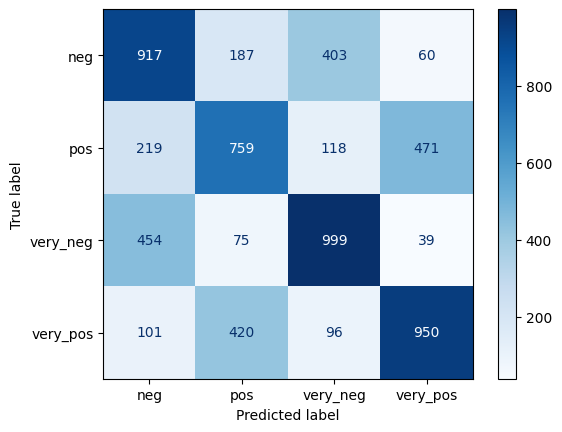

In [22]:
cm = confusion_matrix(y_test, predictions, labels=lgre_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgre_clf.classes_)
disp.plot(cmap=plt.cm.Blues)

**14)** Train a Deep Learning model of your choice (e.g., MLP, RNN) using the document-term representation built in point (10) and evaluate it on test data. Try to maximize the model accuracy.

Note: Models Dictionary is defined on point 11

In [26]:
mlp = MLPClassifier(max_iter=500, random_state=42)
mlp.fit(X_train_features, y_train)

MLPClassifier(max_iter=500, random_state=42)

In [27]:
mlp_predictions = mlp.predict(vectorizer.transform(X_test["reviewText"]))
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print(f"Accuracy (MLP): {mlp_accuracy:.2%}")

Accuracy (MLP): 52.20%


**15)** Get the predictions of this latter model and compare them with the Logistic Regression model trained in point (11) using the chi-square test at a confidence level of 95% (i.e. p-value must be <= 0.05 for models to be significantly different).

Hint: you will need to convert the predictions of both models into integer arrays for comparison.


To calculate the p-value, you can use the provided `chi2_pval`, inputting the arrays containing the predicted labels from the two models as well as the true labels.

```
chi2_pval(model1_predictions, model2_predictions, y_test)
```

In [28]:
from scipy.stats import chi2_contingency

def chi2_pval(p1, p2, y_test):
    num_classes = len(np.unique(y_test))
    num_instances = len(y_test)

    model1_errors = p1 != y_test
    model2_errors = p2 != y_test

    # Construct contingency table
    contingency_table = pd.crosstab(model1_errors, model2_errors)
    print(contingency_table)

    # Calculate Chi-square test statistic and p-value
    q_statistic, p_value = chi2_contingency(contingency_table, correction=False)[:2]

    return p_value

In [42]:
swapped_label_dict = {value: key for key, value in label_dict.items()}
int_lgre_predictions = [int(swapped_label_dict[pred]) for pred in predictions]
int_mlp_predictions = [int(swapped_label_dict[pred]) for pred in mlp_predictions]
int_y_test = [int(swapped_label_dict[pred]) for pred in y_test]

# print(f"Logistic Regression predictions: {predictions[:5]}")
# print(f"MLP predictions: {mlp_predictions}")
# display(y_test)

chi2_pval(int_lgre_predictions, int_mlp_predictions, y_test)

label  True
label      
True   6268


1.0

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for Logistic Regression model
lr_classification_report = classification_report(int_y_test, int_lr_predictions, target_names=['Class 0', 'Class 1'])
print("Logistic Regression Classification Report:")
print(lr_classification_report)

# Generate classification report for MLP model
mlp_classification_report = classification_report(int_y_test, int_mlp_predictions, target_names=['Class 0', 'Class 1'])
print("\nMLP Classification Report:")
print(mlp_classification_report)